<h1 align='center'>A/B Testing for New Card Launch</h1>

<h2> Importing Necessarry Libraries and Setting up Connection to DB <h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import os
import dotenv

In [ ]:
dotenv.load_dotenv("./env")

uri = os.getenv("URI")
engine = create_engine(
    uri,
    connect_args={
        "connect_timeout": 10,
        "read_timeout": 10,
        "write_timeout": 10,
        "charset": "utf8mb4",
        "ssl": {"ssl_ca": os.path.join(os.getcwd(), "ca.pem")},
    },
)
conn = engine.connect()

In [ ]:
raw_data_path = os.path.join(os.getcwd(), "data/raw")
os.makedirs(raw_data_path, exist_ok=True)

if not os.listdir(raw_data_path):
    pd.read_sql("SELECT * FROM customers", conn).to_csv(
        os.path.join(raw_data_path, "customers.csv"), index=False
    )
    pd.read_sql("SELECT * FROM transactions", conn).to_csv(
        os.path.join(raw_data_path, "transactions.csv"), index=False
    )
    pd.read_sql("SELECT * FROM credit_profiles", conn).to_csv(
        os.path.join(raw_data_path, "credit_profiles.csv"), index=False
    )
    pd.read_sql("SELECT * FROM avg_transactions_after_campaign", conn).to_csv(
        os.path.join(raw_data_path, "avg_transactions_after_campaign.csv"), index=False
    )

In [4]:
df_customers = pd.read_csv("data/raw/customers.csv")
df_transactions = pd.read_csv("data/raw/transactions.csv")
df_credit_profiles = pd.read_csv("data/raw/credit_profiles.csv")
df_avg_transactions_after_campaign = pd.read_csv("data/raw/avg_transactions_after_campaign.csv")

<h2>Data Cleaning</h2>

<h3>Cleaning df_customers</h3>

In [5]:
df_customers.head(10)

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Manya Acharya,Female,2,City,Business Owner,358211.0,Married
1,2,Anjali Pandey,Female,47,City,Consultant,65172.0,Single
2,3,Aaryan Chauhan,Male,21,City,Freelancer,22378.0,Married
3,4,Rudra Bali,Male,24,Rural,Freelancer,33563.0,Married
4,5,Advait Malik,Male,48,City,Consultant,39406.0,Married
5,6,Arya Das,Male,22,City,Freelancer,44887.0,Married
6,7,Avyanna Soni,Female,32,Suburb,Business Owner,259013.0,Married
7,8,Yash Vernekar,Male,27,City,Freelancer,159400.0,Married
8,9,Vihaan Agarwal,Male,21,Suburb,Fullstack Developer,34814.0,Single
9,10,Aditya Choudhary,Male,25,Rural,Freelancer,39832.0,Married


In [6]:
df_customers.describe()

,cust_id,age,annual_income
count,1000.000000,1000.000000,950.000000
mean,500.500000,36.405000,139410.314737
std,288.819436,15.666155,112416.802007
min,1.000000,1.000000,2.000000
25%,250.750000,26.000000,47627.500000
50%,500.500000,32.000000,112218.500000
75%,750.250000,46.000000,193137.500000
max,1000.000000,135.000000,449346.000000


In [7]:
df_customers[df_customers["annual_income"].isnull()]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
14,15,Sanjana Malik,Female,25,Rural,Artist,NaN,Married
82,83,Reyansh Mukherjee,Male,27,City,Freelancer,NaN,Single
97,98,Virat Puri,Male,47,Suburb,Business Owner,NaN,Married
102,103,Aarav Shah,Male,32,City,Data Scientist,NaN,Married
155,156,Kiaan Saxena,Male,24,City,Fullstack Developer,NaN,Married
170,171,Advait Verma,Male,52,City,Business Owner,NaN,Single
186,187,Samar Sardar,Male,53,City,Consultant,NaN,Single
192,193,Ishan Joshi,Male,37,Suburb,Data Scientist,NaN,Married
227,228,Advait Mukherjee,Male,48,City,Business Owner,NaN,Married
232,233,Aditya Goel,Male,26,City,Freelancer,NaN,Married


In [8]:
df_customers.isnull().sum()

cust_id            0
name               0
gender             0
age                0
location           0
occupation         0
annual_income     50
marital_status     0
dtype: int64

In [9]:
occupation_wise_income_median = (
    df_customers.groupby(["occupation", "location"])["annual_income"]
    .median()
    .reset_index()
)
occupation_wise_income_median.columns = [
    "occupation",
    "location",
    "annual_income_median",
]
occupation_wise_income_median

,occupation,location,annual_income_median
0,Accountant,City,66751.0
1,Accountant,Rural,55371.5
2,Accountant,Suburb,66819.0
3,Artist,City,46710.0
4,Artist,Rural,35667.0
5,Artist,Suburb,47426.0
6,Business Owner,City,274521.0
7,Business Owner,Rural,217684.0
8,Business Owner,Suburb,260057.0
9,Consultant,City,53075.0


In [ ]:
def replace_income(row) -> int | float:
    """
    Replace missing annual income with the median income of the respective occupation.
    If the annual income is not missing, return the original value.
    Parameters 
    row: A row from the DataFrame.
    Returns: The annual income, either the original value or the median of the occupation.
    """
    if pd.isnull(row["annual_income"]):
        return occupation_wise_income_median.loc[
            (occupation_wise_income_median["occupation"] == row["occupation"])
            & (occupation_wise_income_median["location"] == row["location"]),
            "annual_income_median",
        ].values[0]
    else:
        return row["annual_income"]

In [11]:
df_customers["annual_income"] = df_customers.apply(replace_income, axis=1)
df_customers[df_customers["annual_income"].isnull()]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status


In [12]:
df_customers.iloc[[6, 14, 82, 97]]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
6,7,Avyanna Soni,Female,32,Suburb,Business Owner,259013.0,Married
14,15,Sanjana Malik,Female,25,Rural,Artist,35667.0,Married
82,83,Reyansh Mukherjee,Male,27,City,Freelancer,44908.0,Single
97,98,Virat Puri,Male,47,Suburb,Business Owner,260057.0,Married


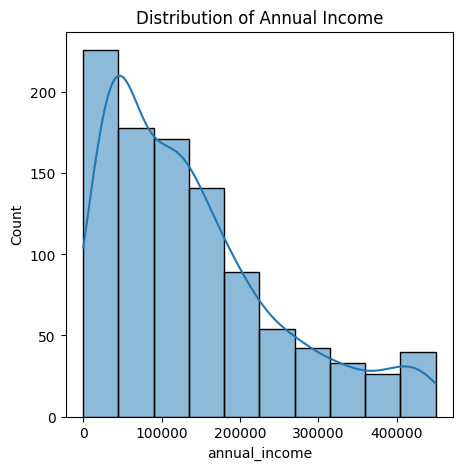

In [13]:
plt.figure(figsize=(5, 5))
plt.title("Distribution of Annual Income")
sns.histplot(df_customers["annual_income"], bins=10, kde=True)
plt.show()

<h3>Checking for Outliers</h3>

In [14]:
df_customers.describe()

,cust_id,age,annual_income
count,1000.000000,1000.000000,1000.000000
mean,500.500000,36.405000,138973.375500
std,288.819436,15.666155,111145.524612
min,1.000000,1.000000,2.000000
25%,250.750000,26.000000,48533.500000
50%,500.500000,32.000000,113416.000000
75%,750.250000,46.000000,192614.000000
max,1000.000000,135.000000,449346.000000


In [15]:
df_customers[df_customers["annual_income"] <= 100]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
31,32,Veer Mistry,Male,50,City,Business Owner,50.0,Married
262,263,Vivaan Tandon,Male,53,Suburb,Business Owner,50.0,Married
316,317,Yuvraj Saxena,Male,47,City,Consultant,50.0,Married
333,334,Avani Khanna,Female,29,City,Data Scientist,50.0,Married
340,341,Priya Sinha,Female,33,Rural,Fullstack Developer,50.0,Married
543,544,Advait Batra,Male,54,City,Consultant,2.0,Married
592,593,Priya Gandhi,Female,32,City,Business Owner,50.0,Married
633,634,Rudra Mehtani,Male,26,City,Data Scientist,2.0,Married
686,687,Vihaan Jaiswal,Male,40,City,Business Owner,2.0,Married
696,697,Ishan Negi,Male,47,City,Consultant,20.0,Married


In [16]:
for index, row in df_customers.iterrows():
    if row["annual_income"] <= 100:
        df_customers.at[index, "annual_income"] = occupation_wise_income_median.loc[
            (occupation_wise_income_median["occupation"] == row["occupation"])
            & (occupation_wise_income_median["location"] == row["location"]),
            "annual_income_median",
        ].values[0]

In [17]:
df_customers.iloc[[31, 262, 316]]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
31,32,Veer Mistry,Male,50,City,Business Owner,274521.0,Married
262,263,Vivaan Tandon,Male,53,Suburb,Business Owner,260057.0,Married
316,317,Yuvraj Saxena,Male,47,City,Consultant,53075.0,Married


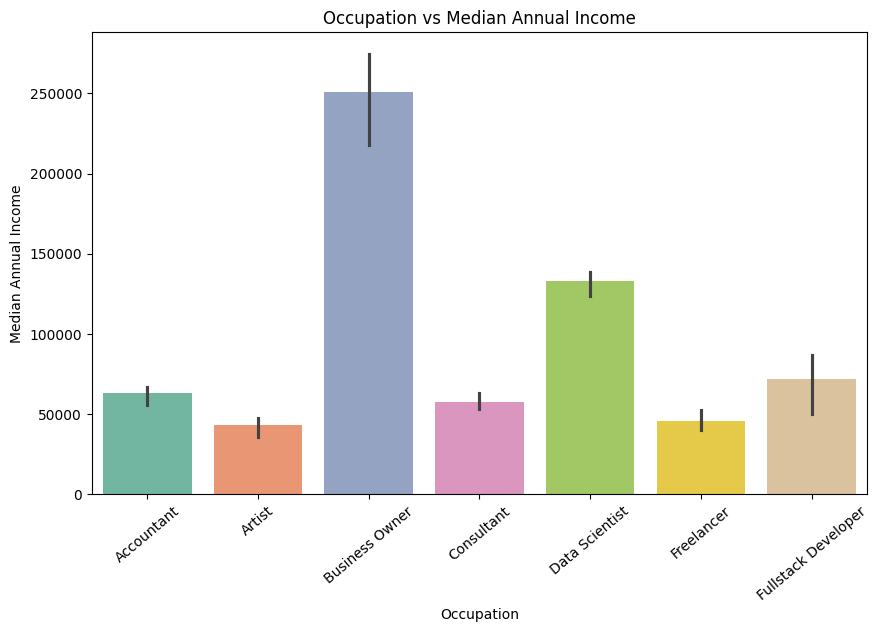

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x=occupation_wise_income_median["occupation"],
    y=occupation_wise_income_median["annual_income_median"],
    hue=occupation_wise_income_median["occupation"],
)
plt.xticks(rotation=40)
plt.title("Occupation vs Median Annual Income")
plt.xlabel("Occupation")
plt.ylabel("Median Annual Income")
plt.show()

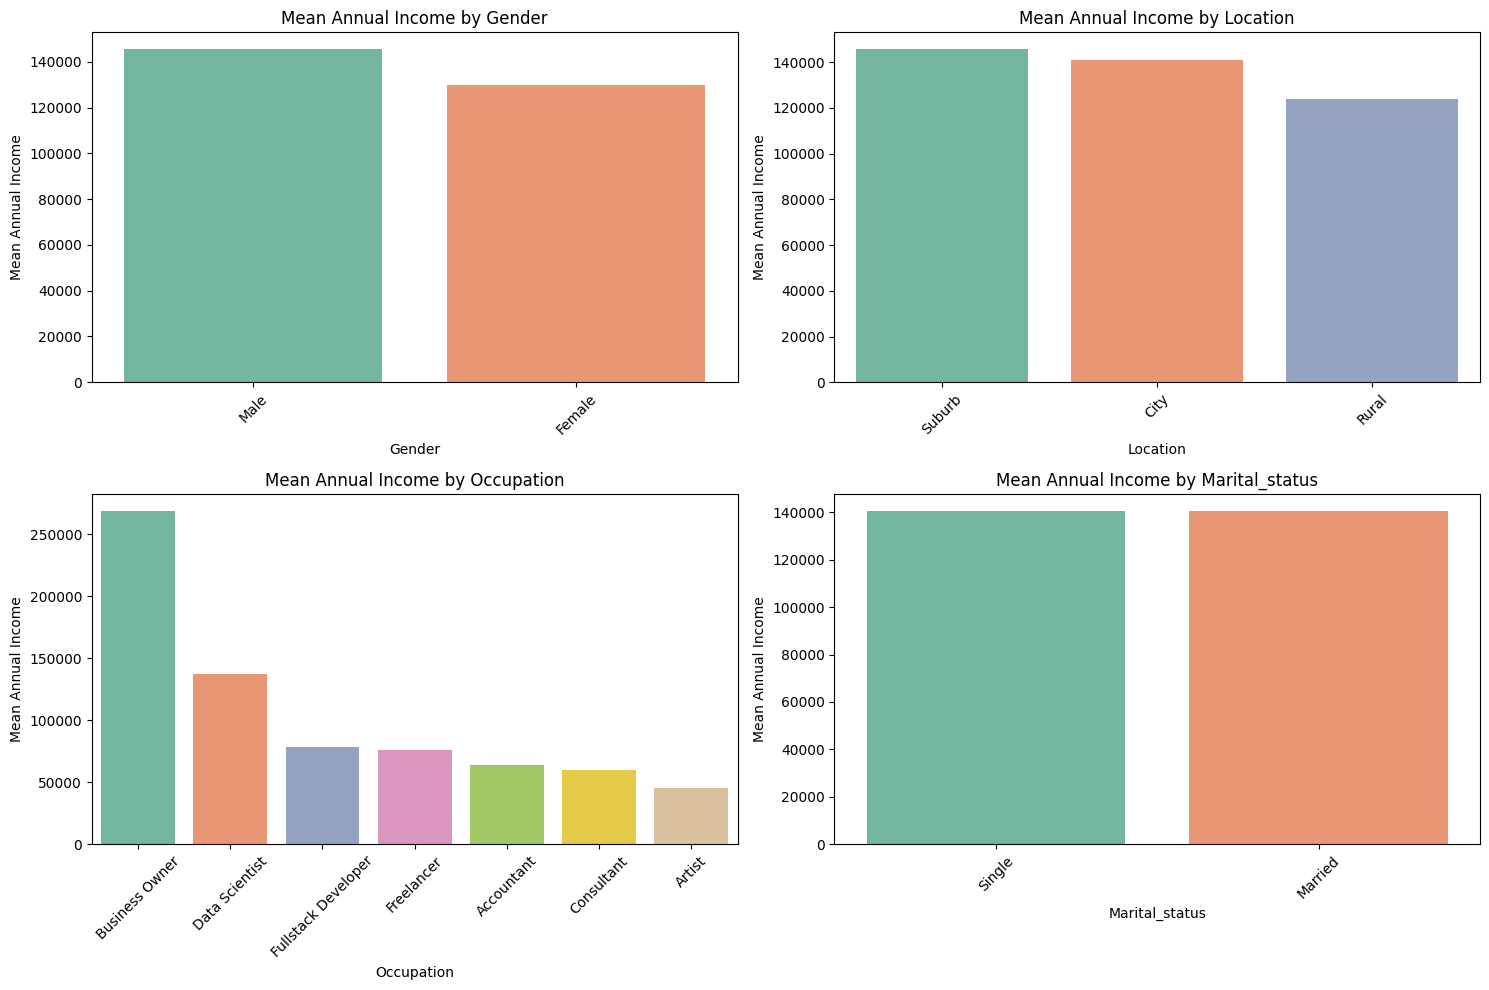

In [ ]:
categorical_columns = df_customers.select_dtypes(include=["object"]).columns.tolist()
if "name" in categorical_columns:
    categorical_columns.remove("name")

num_plots = len(categorical_columns)
ncols = 2
nrows = int(np.ceil(num_plots / ncols))

plt.figure(figsize=(15, 5 * nrows))

for i, column in enumerate(categorical_columns):
    plt.subplot(nrows, ncols, i + 1)

    mean_income_per_group = (
        df_customers.groupby(column)["annual_income"]
        .mean()
        .reset_index()
        .sort_values(by="annual_income", ascending=False)
    )
    sns.barplot(
        data=mean_income_per_group,
        x=mean_income_per_group[column],
        y=mean_income_per_group["annual_income"],
        hue=mean_income_per_group[column],
        dodge=False,
    )
    plt.title(f"Mean Annual Income by {column.capitalize()}")
    plt.xlabel(column.capitalize())
    plt.ylabel("Mean Annual Income")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [20]:
df_customers["age"].describe()

count    1000.000000
mean       36.405000
std        15.666155
min         1.000000
25%        26.000000
50%        32.000000
75%        46.000000
max       135.000000
Name: age, dtype: float64

In [21]:
df_customers[(df_customers["age"] < 15) | (df_customers["age"] >= 80)]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Manya Acharya,Female,2,City,Business Owner,358211.0,Married
41,42,Aaryan Shah,Male,110,City,Artist,7621.0,Married
165,166,Sia Dutta,Female,1,City,Freelancer,39721.0,Single
174,175,Rohan Sharma,Male,110,City,Freelancer,23723.0,Married
222,223,Arjun Batra,Male,110,Suburb,Freelancer,210987.0,Married
277,278,Aarav Tandon,Male,110,City,Consultant,96522.0,Single
295,296,Ayush Pandey,Male,1,Rural,Accountant,55254.0,Married
325,326,Virat Goel,Male,110,City,Accountant,61021.0,Single
610,611,Rehan Verma,Male,135,Rural,Business Owner,444776.0,Married
692,693,Dhruv Jha,Male,1,City,Business Owner,83045.0,Married


In [22]:
df_customers.iloc[[41, 165, 174, 5]]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
41,42,Aaryan Shah,Male,110,City,Artist,7621.0,Married
165,166,Sia Dutta,Female,1,City,Freelancer,39721.0,Single
174,175,Rohan Sharma,Male,110,City,Freelancer,23723.0,Married
5,6,Arya Das,Male,22,City,Freelancer,44887.0,Married


In [23]:
median_age_by_categoricals = (
    df_customers.groupby(["gender", "occupation", "marital_status", "location"])["age"]
    .median()
    .reset_index()
)
median_age_by_categoricals.columns = [
    "gender",
    "occupation",
    "marital_status",
    "location",
    "age_median",
]
median_age_by_categoricals["age_median"] = np.floor(
    median_age_by_categoricals["age_median"]
).astype(int)
median_age_by_categoricals

,gender,occupation,marital_status,location,age_median
0,Female,Accountant,Married,City,31
1,Female,Accountant,Married,Suburb,25
2,Female,Artist,Married,City,25
3,Female,Artist,Married,Rural,25
4,Female,Artist,Married,Suburb,27
...,...,...,...,...,...
67,Male,Fullstack Developer,Married,Rural,24
68,Male,Fullstack Developer,Married,Suburb,26
69,Male,Fullstack Developer,Single,City,28
70,Male,Fullstack Developer,Single,Rural,29


In [24]:
df_customers["age"] = np.floor(df_customers["age"]).astype(int)
for index, row in df_customers.iterrows():

    if row["age"] <= 15 or row["age"] > 80:

        df_customers.at[index, "age"] = median_age_by_categoricals.loc[

            (median_age_by_categoricals["occupation"] == row["occupation"])

            & (median_age_by_categoricals["gender"] == row["gender"])

            & (median_age_by_categoricals["marital_status"] == row["marital_status"]),

            "age_median",

        ].values[0]

df_customers[df_customers["age"] < 15]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status


In [25]:
df_customers.describe()

,cust_id,age,annual_income
count,1000.000000,1000.000000,1000.000000
mean,500.500000,35.613000,140539.262500
std,288.819436,12.505904,110713.766355
min,1.000000,18.000000,5175.000000
25%,250.750000,26.000000,49748.250000
50%,500.500000,32.000000,115328.000000
75%,750.250000,44.250000,195514.250000
max,1000.000000,110.000000,449346.000000


**To address a singular instance of an age of 110, which is an anomaly, I am correcting this by substituting it with the median age of the corresponding group based on gender, occupation, marital status, and location.**

In [ ]:
median_age_by_profession = (
    df_customers.groupby(["occupation", "gender"])["age"].median().reset_index()
)

median_age_value = median_age_by_profession.loc[
    (median_age_by_profession["occupation"] == "Accountant")
    & (median_age_by_profession["gender"] == "Male"),
    "age",
].values[0]

df_customers.loc[
    (df_customers["occupation"] == "Accountant")
    & (df_customers["gender"] == "Male")
    & (df_customers["age"] == 110),
    "age",
] = median_age_value

df_customers[df_customers["age"] == 110]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status


In [ ]:
bins = [17, 25, 48, 65]
labels = ["18-25", "26-48", "49-65"]
df_customers["age_group"] = pd.cut(
    df_customers["age"], bins=bins, labels=labels, right=False
)

df_customers[df_customers["age_group"].isnull()]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group


In [28]:
df_customers["age_group"].value_counts()

age_group
26-48    598
49-65    204
18-25    198
Name: count, dtype: int64

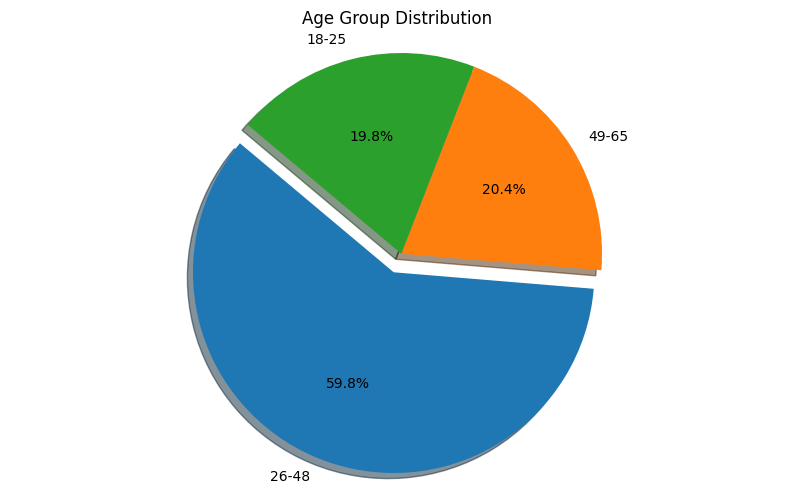

In [29]:
plt.figure(figsize=(10, 6))
plt.title("Age Group Distribution")
plt.pie(
    df_customers["age_group"].value_counts(),
    labels=df_customers["age_group"].value_counts().index,
    autopct="%1.1f%%",
    startangle=140,
    explode=(0.1, 0, 0),
    shadow=True,
)
plt.axis("equal")
plt.show()

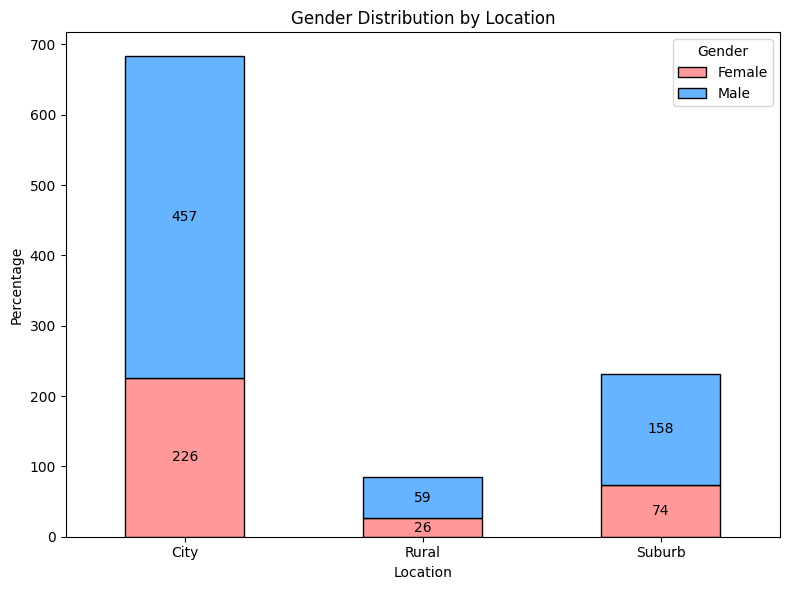

In [30]:
df_gender_by_location = df_customers.groupby(["location", "gender"]).size().unstack()

# Plot stacked bar chart
ax = df_gender_by_location.plot(
    kind="bar",
    stacked=True,
    figsize=(8, 6),
    color=["#FF9999", "#66B3FF"],
    edgecolor="black",
    width=0.5,
)

# Add percentage labels
for c in ax.containers:
    ax.bar_label(c, label_type="center", fontsize=10, color="black")

ax.set_ylabel("Percentage")
ax.set_xlabel("Location")
plt.title("Gender Distribution by Location")
plt.xticks(rotation=0)
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

In [ ]:
os.makedirs("data/clean", exist_ok=True)
df_customers.to_csv(
    os.path.join(os.getcwd(), "data/clean/customers_clean.csv"), index=False
)

<h3>Exploring Credit Score Table</h3>

In [32]:
df_credit_profiles.head(10)

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
0,1,749,0.585171,19571.0,0.0,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0
2,3,544,0.854807,513.0,4.0,1000.0
3,4,504,0.336938,224.0,2.0,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0
5,6,442,0.705409,246.0,4.0,500.0
6,7,747,0.523965,15544.0,4.0,40000.0
7,8,482,0.121775,76.0,2.0,750.0
8,9,537,0.448924,341.0,0.0,1000.0
9,10,567,0.533402,522.0,0.0,1250.0


In [33]:
df_credit_profiles.shape

(1004, 6)

In [34]:
df_customers.shape

(1000, 9)

In [35]:
df_credit_profiles["cust_id"].nunique()

1000

In [36]:
df_credit_profiles[df_credit_profiles["cust_id"].duplicated(keep=False)]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
516,517,308,NaN,NaN,NaN,NaN
517,517,308,0.113860,33.0,3.0,500.0
569,569,344,NaN,NaN,NaN,NaN
570,569,344,0.112599,37.0,0.0,500.0
607,606,734,NaN,NaN,NaN,NaN
608,606,734,0.193418,4392.0,1.0,40000.0
664,662,442,NaN,NaN,NaN,NaN
665,662,442,0.856039,266.0,2.0,500.0


In [37]:
df_credit_profiles.drop_duplicates(subset="cust_id", keep="last", inplace=True)
df_credit_profiles.shape

(1000, 6)

In [38]:
df_credit_profiles.isnull().sum()

cust_id                            0
credit_score                       0
credit_utilisation                 0
outstanding_debt                   0
credit_inquiries_last_6_months     0
credit_limit                      65
dtype: int64

In [39]:
df_credit_profiles[df_credit_profiles["credit_limit"].isnull()]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
10,11,679,0.557450,9187.0,2.0,NaN
35,36,790,0.112535,4261.0,1.0,NaN
37,38,514,0.296971,238.0,2.0,NaN
45,46,761,0.596041,24234.0,2.0,NaN
64,65,734,0.473715,13631.0,0.0,NaN
...,...,...,...,...,...,...
912,909,479,0.487555,320.0,3.0,NaN
931,928,311,0.832244,316.0,2.0,NaN
948,945,526,0.272734,227.0,1.0,NaN
954,951,513,0.175914,131.0,3.0,NaN


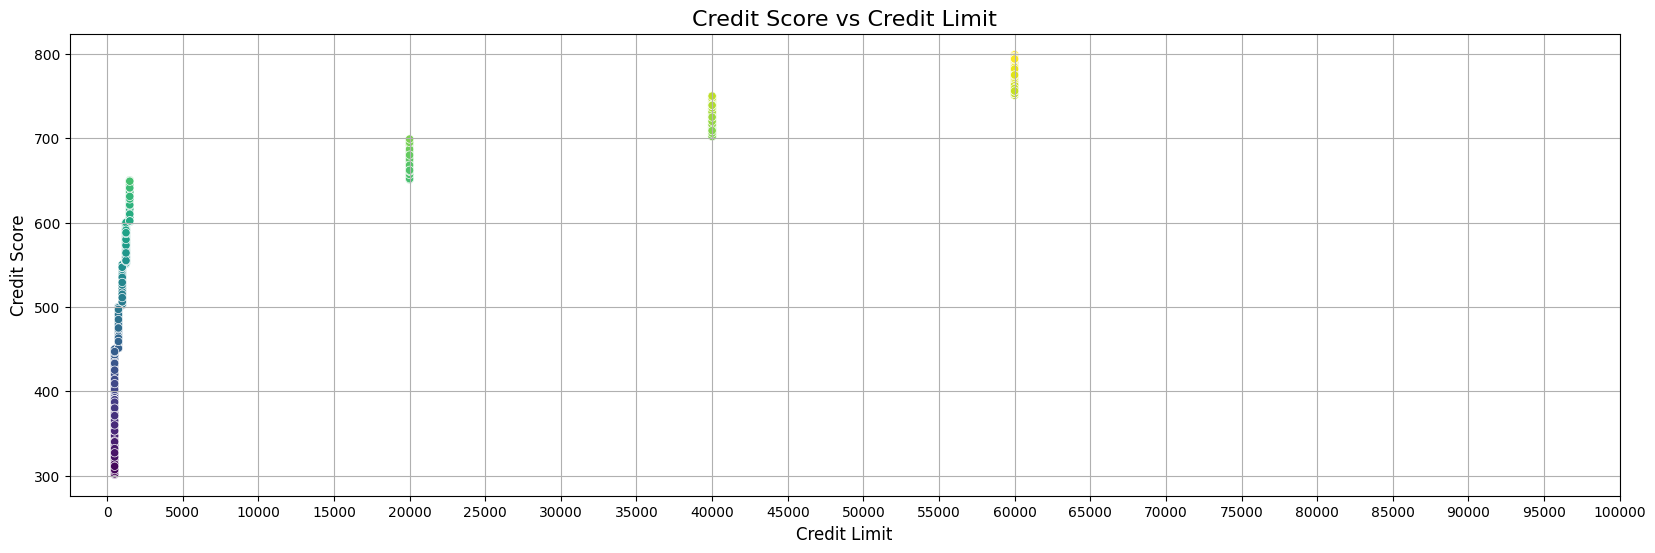

In [ ]:
plt.figure(figsize=(20, 6))
plt.title("Credit Score vs Credit Limit", fontsize=16)
plt.xlabel("Credit Limit", fontsize=12)
plt.ylabel("Credit Score", fontsize=12)

sns.scatterplot(
    x="credit_limit",
    y="credit_score",
    data=df_credit_profiles,
    hue="credit_score",
    palette="viridis",
    legend=False,
)

plt.grid(True)
plt.xticks(range(0, 80001, 10000))
plt.show()

In [41]:
bins = [i for i in range(300, 801, 50)]
labels = [f"{start}-{end - 1}" for start, end in zip(bins, bins[1:])]

df_credit_profiles["credit_score_range"] = pd.cut(
    df_credit_profiles["credit_score"],
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True,
)

In [42]:
df_credit_profiles["credit_score_range"].value_counts()

credit_score_range
750-799    213
700-749    142
600-649    105
400-449     95
500-549     95
450-499     82
550-599     80
300-349     76
350-399     66
650-699     46
Name: count, dtype: int64

In [43]:
credit_limit_mode = (
    df_credit_profiles.groupby("credit_score_range", observed=True)["credit_limit"]
    .agg(lambda x: x.mode()[0])
    .reset_index()
)

credit_limit_mode

,credit_score_range,credit_limit
0,300-349,500.0
1,350-399,500.0
2,400-449,500.0
3,450-499,750.0
4,500-549,1000.0
5,550-599,1250.0
6,600-649,1500.0
7,650-699,20000.0
8,700-749,40000.0
9,750-799,60000.0


In [ ]:
df_credit_profiles[df_credit_profiles["credit_limit"].isnull()].sample(
    n=10, random_state=42
)

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range
802,799,508,0.255638,168.0,2.0,NaN,500-549
912,909,479,0.487555,320.0,3.0,NaN,450-499
10,11,679,0.557450,9187.0,2.0,NaN,650-699


In [45]:
df_credit_profiles = df_credit_profiles.merge(
    credit_limit_mode, on="credit_score_range", how="left"
)

df_credit_profiles["credit_limit_x"] = df_credit_profiles[
    "credit_limit_x"
].fillna(df_credit_profiles["credit_limit_y"])

df_credit_profiles = df_credit_profiles.drop(columns="credit_limit_y")
df_credit_profiles = df_credit_profiles.rename(
    columns={"credit_limit_x": "credit_limit"}
)

df_credit_profiles.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range
0,1,749,0.585171,19571.0,0.0,40000.0,700-749
1,2,587,0.107928,161644.0,2.0,1250.0,550-599
2,3,544,0.854807,513.0,4.0,1000.0,500-549
3,4,504,0.336938,224.0,2.0,1000.0,500-549
4,5,708,0.586151,18090.0,2.0,40000.0,700-749


In [ ]:
df_credit_profiles[df_credit_profiles["credit_limit"].isnull()]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range


In [47]:
df_credit_profiles.describe()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,500.500000,589.182000,0.498950,9683.597000,1.955000,19733.75000
std,288.819436,152.284929,0.233139,25255.893671,1.414559,24717.43818
min,1.000000,300.000000,0.103761,33.000000,0.000000,500.00000
25%,250.750000,460.000000,0.293917,221.000000,1.000000,750.00000
50%,500.500000,601.500000,0.487422,550.000000,2.000000,1500.00000
75%,750.250000,738.000000,0.697829,11819.500000,3.000000,40000.00000
max,1000.000000,799.000000,0.899648,209901.000000,4.000000,60000.00000


<Axes: xlabel='outstanding_debt'>

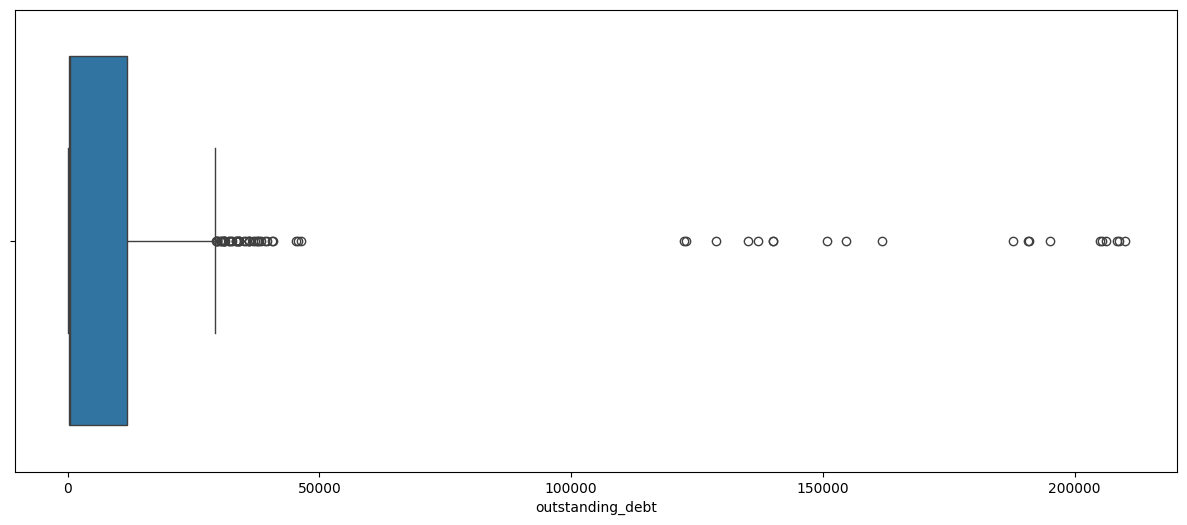

In [48]:
plt.figure(figsize=(15, 6))
sns.boxplot(x=df_credit_profiles.outstanding_debt)

In [ ]:
df_credit_profiles[
    df_credit_profiles["outstanding_debt"] > df_credit_profiles["credit_limit"]
]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range
1,2,587,0.107928,161644.0,2.0,1250.0,550-599
19,20,647,0.439132,205014.0,3.0,1500.0,600-649
25,26,758,0.250811,190838.0,2.0,60000.0,750-799
38,39,734,0.573023,122758.0,3.0,40000.0,700-749
93,94,737,0.739948,137058.0,2.0,40000.0,700-749
204,205,303,0.364360,187849.0,0.0,500.0,300-349
271,272,703,0.446886,154568.0,1.0,40000.0,700-749
301,302,722,0.608076,122402.0,4.0,40000.0,700-749
330,331,799,0.363420,208898.0,4.0,60000.0,750-799
350,351,320,0.285081,150860.0,0.0,500.0,300-349


In [50]:
df_credit_profiles.loc[
    df_credit_profiles["outstanding_debt"]
    > df_credit_profiles["credit_limit"],
    "outstanding_debt",
] = df_credit_profiles["credit_limit"]

In [ ]:
df_credit_profiles[
    df_credit_profiles["outstanding_debt"] > df_credit_profiles["credit_limit"]
]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range


In [52]:
df_credit_profiles.iloc[[1, 25]]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range
1,2,587,0.107928,1250.0,2.0,1250.0,550-599
25,26,758,0.250811,60000.0,2.0,60000.0,750-799


In [53]:
df_customer_profiles_merged = pd.merge(
    left=df_customers, right=df_credit_profiles, how="inner", on="cust_id"
)
df_customer_profiles_merged.head(10)

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range
0,1,Manya Acharya,Female,51,City,Business Owner,358211.0,Married,49-65,749,0.585171,19571.0,0.0,40000.0,700-749
1,2,Anjali Pandey,Female,47,City,Consultant,65172.0,Single,26-48,587,0.107928,1250.0,2.0,1250.0,550-599
2,3,Aaryan Chauhan,Male,21,City,Freelancer,22378.0,Married,18-25,544,0.854807,513.0,4.0,1000.0,500-549
3,4,Rudra Bali,Male,24,Rural,Freelancer,33563.0,Married,18-25,504,0.336938,224.0,2.0,1000.0,500-549
4,5,Advait Malik,Male,48,City,Consultant,39406.0,Married,49-65,708,0.586151,18090.0,2.0,40000.0,700-749
5,6,Arya Das,Male,22,City,Freelancer,44887.0,Married,18-25,442,0.705409,246.0,4.0,500.0,400-449
6,7,Avyanna Soni,Female,32,Suburb,Business Owner,259013.0,Married,26-48,747,0.523965,15544.0,4.0,40000.0,700-749
7,8,Yash Vernekar,Male,27,City,Freelancer,159400.0,Married,26-48,482,0.121775,76.0,2.0,750.0,450-499
8,9,Vihaan Agarwal,Male,21,Suburb,Fullstack Developer,34814.0,Single,18-25,537,0.448924,341.0,0.0,1000.0,500-549
9,10,Aditya Choudhary,Male,25,Rural,Freelancer,39832.0,Married,26-48,567,0.533402,522.0,0.0,1250.0,550-599


In [54]:
numerical_cols = df_customer_profiles_merged.select_dtypes(
    include=["float64", "int64"]
).columns.tolist()
exclude_cols = ["cust_id", "credit_inquiries_last_6_months"]

numerical_cols = [col for col in numerical_cols if col not in exclude_cols]

corr_matrix = df_customer_profiles_merged[numerical_cols].corr()
corr_matrix

,age,annual_income,credit_score,credit_utilisation,outstanding_debt,credit_limit
age,1.000000,0.619066,0.444567,-0.027975,0.444295,0.510955
annual_income,0.619066,1.000000,0.576412,-0.085592,0.556803,0.685274
credit_score,0.444567,0.576412,1.000000,-0.070445,0.680654,0.847952
credit_utilisation,-0.027975,-0.085592,-0.070445,1.000000,0.192838,-0.080493
outstanding_debt,0.444295,0.556803,0.680654,0.192838,1.000000,0.810581
credit_limit,0.510955,0.685274,0.847952,-0.080493,0.810581,1.000000


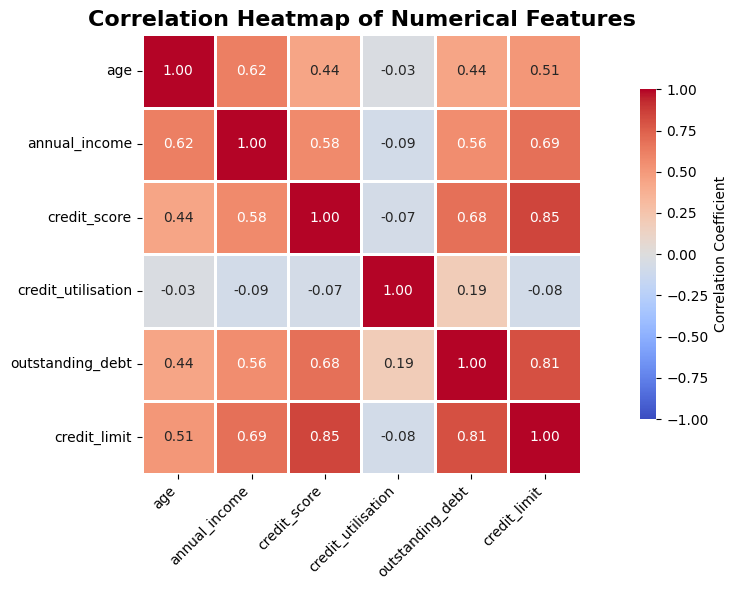

In [55]:
plt.figure(figsize=(12, 6))
plt.title("Correlation Heatmap of Numerical Features", fontsize=16, fontweight="bold")

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.8,
    cbar_kws={"shrink": 0.75, "label": "Correlation Coefficient"},
)

plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels
plt.yticks(rotation=0)
plt.tight_layout()  # Prevent cutoff
plt.show()

### Transactions Table

In [56]:
df_transactions.head(10)

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68,Amazon,Fashion & Apparel,Net Banking
5,6,527,2023-01-01,38,Shopify,Fashion & Apparel,Debit Card
6,7,388,2023-01-01,720,Alibaba,Electronics,Credit Card
7,8,8,2023-01-01,140,Shopify,Kitchen Appliances,Gpay
8,9,939,2023-01-01,144,Alibaba,Beauty & Personal Care,Phonepe
9,10,228,2023-01-01,836,Ebay,Electronics,Gpay


In [ ]:
df_transactions["tran_amount"].describe()

count    500000.00000
mean       3225.20733
std       13098.74276
min           0.00000
25%          64.00000
50%         141.00000
75%         397.00000
max       69999.00000
Name: tran_amount, dtype: float64

In [58]:
df_transactions.isnull().sum()

tran_id                0
cust_id                0
tran_date              0
tran_amount            0
platform            4941
product_category       0
payment_type           0
dtype: int64

In [59]:
df_transactions[df_transactions["platform"].isnull()]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
355,356,58,2023-01-01,237,NaN,Electronics,Net Banking
418,419,383,2023-01-01,338,NaN,Electronics,Credit Card
607,608,421,2023-01-01,700,NaN,Electronics,Phonepe
844,845,945,2023-01-01,493,NaN,Sports,Credit Card
912,913,384,2023-01-01,85,NaN,Fashion & Apparel,Phonepe
...,...,...,...,...,...,...,...
499579,499580,924,2023-09-05,31,NaN,Fashion & Apparel,Gpay
499646,499647,944,2023-09-05,58445,NaN,Fashion & Apparel,Phonepe
499725,499726,620,2023-09-05,15,NaN,Sports,Net Banking
499833,499834,616,2023-09-05,97,NaN,Fashion & Apparel,Credit Card


In [60]:
df_transactions["platform"].value_counts()

platform
Amazon      151443
Flipkart    122660
Alibaba      73584
Meesho       73271
Shopify      39416
Cred         24741
Ebay          9944
Name: count, dtype: int64

In [61]:
print("Missing before:", df_transactions["platform"].isna().sum())

df_transactions["platform"] = df_transactions.groupby("product_category")[
    "platform"
].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x)

print("Missing after:", df_transactions["platform"].isna().sum())

Missing before: 4941
Missing after: 0


In [62]:
df_transactions.iloc[[355, 418, 607]]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
355,356,58,2023-01-01,237,Amazon,Electronics,Net Banking
418,419,383,2023-01-01,338,Amazon,Electronics,Credit Card
607,608,421,2023-01-01,700,Amazon,Electronics,Phonepe


In [63]:
df_transactions["platform"].value_counts()

platform
Amazon      156384
Flipkart    122660
Alibaba      73584
Meesho       73271
Shopify      39416
Cred         24741
Ebay          9944
Name: count, dtype: int64

In [ ]:
df_transactions_non_zero = df_transactions[df_transactions["tran_amount"] > 0]
df_transactions_non_zero.sample(n=10, random_state=42)

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
495625,495626,41,2023-09-03,181,Alibaba,Home Decor,Phonepe
433274,433275,298,2023-08-03,52,Flipkart,Beauty & Personal Care,Phonepe
289227,289228,898,2023-05-24,153,Flipkart,Sports,Gpay
163664,163665,92,2023-03-23,16,Meesho,Fashion & Apparel,Phonepe
411097,411098,732,2023-07-23,135,Meesho,Kitchen Appliances,Phonepe


In [ ]:
median_val = df_transactions["tran_amount"].median()

df_transactions["tran_amount"] = df_transactions["tran_amount"].replace(0, median_val)

In [66]:
df_transactions.sample(10, random_state=42)

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
104241,104242,1,2023-02-21,448,Alibaba,Sports,Net Banking
199676,199677,691,2023-04-10,108,Alibaba,Fashion & Apparel,Phonepe
140199,140200,212,2023-03-11,62,Cred,Fashion & Apparel,Phonepe
132814,132815,143,2023-03-07,243,Cred,Sports,Gpay
408697,408698,752,2023-07-22,86,Flipkart,Fashion & Apparel,Debit Card
163280,163281,598,2023-03-23,76,Flipkart,Kitchen Appliances,Credit Card
215758,215759,898,2023-04-17,109,Amazon,Beauty & Personal Care,Credit Card
442316,442317,746,2023-08-08,202,Cred,Sports,Net Banking
6940,6941,885,2023-01-04,348,Amazon,Kitchen Appliances,Gpay
382310,382311,400,2023-07-09,914,Shopify,Electronics,Debit Card


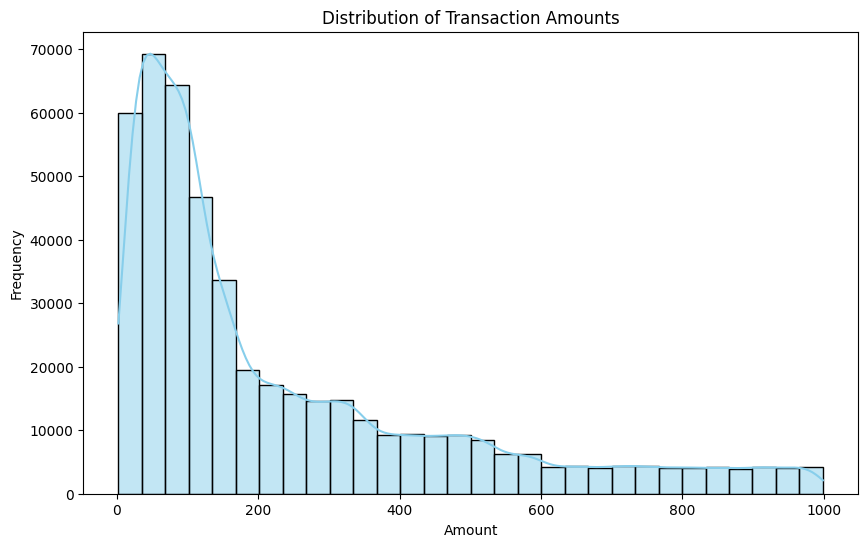

In [67]:
plt.figure(figsize=(10, 6))
plt.title("Distribution of Transaction Amounts")

sns.histplot(
    df_transactions[df_transactions["tran_amount"] < 10000]["tran_amount"],
    bins=30,
    kde=True,
    color="Skyblue",
)
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

In [68]:
Q1, Q3 = df_transactions["tran_amount"].quantile([0.25, 0.75])
IQR = Q3 - Q1

lower = Q1 - (2 * IQR)
upper = Q3 + (2 * IQR)

lower, upper

(-596.0, 1059.0)

In [69]:
df_transactions_outliers = df_transactions[df_transactions["tran_amount"] > upper]
df_transactions_outliers.sample(n=10, random_state=42)

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
134742,134743,299,2023-03-08,50416,Shopify,Kitchen Appliances,Gpay
480310,480311,767,2023-08-27,50173,Meesho,Electronics,Credit Card
190080,190081,885,2023-04-05,67521,Alibaba,Electronics,Net Banking
271480,271481,161,2023-05-15,66610,Alibaba,Toys & Games,Gpay
279095,279096,358,2023-05-19,69972,Meesho,Electronics,Debit Card
147099,147100,431,2023-03-14,57861,Alibaba,Electronics,Gpay
114264,114265,28,2023-02-26,67308,Flipkart,Electronics,Net Banking
256413,256414,508,2023-05-08,69725,Alibaba,Electronics,Debit Card
67501,67502,205,2023-02-03,54001,Ebay,Fashion & Apparel,Gpay
187974,187975,724,2023-04-04,67432,Amazon,Sports,Phonepe


In [70]:
df_transactions_outliers.shape

(25000, 7)

In [71]:
median_by_category = (
    df_transactions.groupby("product_category")["tran_amount"].median().reset_index()
)
median_by_category.rename(columns={"tran_amount": "median_tran_amount"}, inplace=True)
median_by_category

,product_category,median_tran_amount
0,Beauty & Personal Care,97.0
1,Books,31.0
2,Electronics,518.0
3,Fashion & Apparel,68.0
4,Garden & Outdoor,132.0
5,Home Decor,319.0
6,Kitchen Appliances,186.0
7,Sports,283.0
8,Toys & Games,53.0


In [72]:
df_transactions = df_transactions.merge(
    median_by_category, on="product_category", how="left"
)
df_transactions.loc[df_transactions_outliers.index, "tran_amount"] = (
    df_transactions.loc[df_transactions_outliers.index, "median_tran_amount"]
)
df_transactions

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type,median_tran_amount
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe,518.0
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card,68.0
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe,283.0
3,4,797,2023-01-01,33,Shopify,Fashion & Apparel,Gpay,68.0
4,5,482,2023-01-01,68,Amazon,Fashion & Apparel,Net Banking,68.0
...,...,...,...,...,...,...,...,...
499995,499996,791,2023-09-05,43,Amazon,Books,Phonepe,31.0
499996,499997,569,2023-09-05,68,Meesho,Fashion & Apparel,Net Banking,68.0
499997,499998,57,2023-09-05,224,Amazon,Garden & Outdoor,Phonepe,132.0
499998,499999,629,2023-09-05,538,Flipkart,Home Decor,Gpay,319.0


In [73]:
df_transactions.drop(columns=["median_tran_amount"], inplace=True)
df_transactions

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68,Amazon,Fashion & Apparel,Net Banking
...,...,...,...,...,...,...,...
499995,499996,791,2023-09-05,43,Amazon,Books,Phonepe
499996,499997,569,2023-09-05,68,Meesho,Fashion & Apparel,Net Banking
499997,499998,57,2023-09-05,224,Amazon,Garden & Outdoor,Phonepe
499998,499999,629,2023-09-05,538,Flipkart,Home Decor,Gpay


In [74]:
df_transactions

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68,Amazon,Fashion & Apparel,Net Banking
...,...,...,...,...,...,...,...
499995,499996,791,2023-09-05,43,Amazon,Books,Phonepe
499996,499997,569,2023-09-05,68,Meesho,Fashion & Apparel,Net Banking
499997,499998,57,2023-09-05,224,Amazon,Garden & Outdoor,Phonepe
499998,499999,629,2023-09-05,538,Flipkart,Home Decor,Gpay


In [75]:
df_transactions.iloc[[134742, 48030, 190080]]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
134742,134743,299,2023-03-08,186,Shopify,Kitchen Appliances,Gpay
48030,48031,686,2023-01-24,156,Flipkart,Beauty & Personal Care,Credit Card
190080,190081,885,2023-04-05,518,Alibaba,Electronics,Net Banking


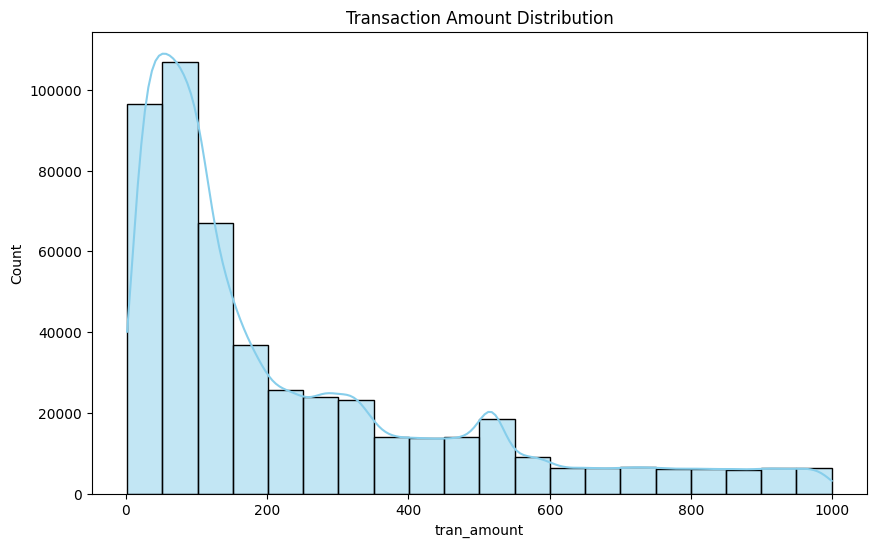

In [76]:
plt.figure(figsize=(10, 6))
plt.title("Transaction Amount Distribution")
sns.histplot(df_transactions["tran_amount"], kde=True, color="skyblue", bins=20)
plt.show()

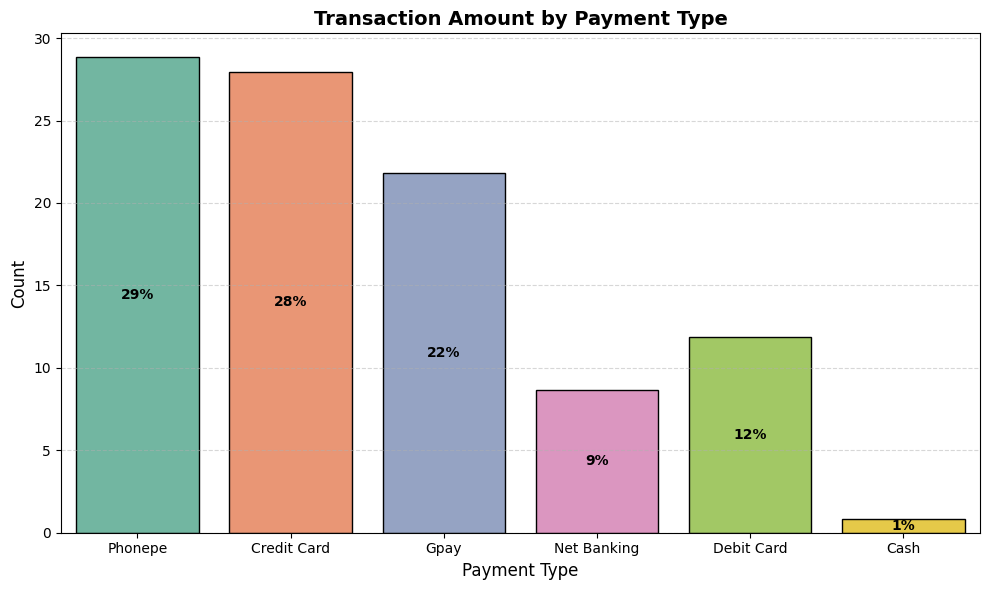

In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Transaction Amount by Payment Type", fontsize=14, fontweight="bold")

ax = sns.countplot(
    data=df_transactions,
    x="payment_type",
    hue="payment_type",
    stat="percent",
    legend=False,
    edgecolor="black",
)

for container in ax.containers:
    ax.bar_label(
        container,
        fmt="%.0f%%",
        label_type="center",
        color="black",
        fontsize=10,
        weight="bold",
    )

plt.xlabel("Payment Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [78]:
df_customer_transactions = pd.merge(
    left=df_customer_profiles_merged,
    right=df_transactions,
    how="inner",
    on="cust_id",
)
df_customer_transactions.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group,credit_score,...,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,tran_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,Manya Acharya,Female,51,City,Business Owner,358211.0,Married,49-65,749,...,19571.0,0.0,40000.0,700-749,1283,2023-01-01,30,Shopify,Fashion & Apparel,Net Banking
1,1,Manya Acharya,Female,51,City,Business Owner,358211.0,Married,49-65,749,...,19571.0,0.0,40000.0,700-749,1382,2023-01-01,96,Amazon,Sports,Debit Card
2,1,Manya Acharya,Female,51,City,Business Owner,358211.0,Married,49-65,749,...,19571.0,0.0,40000.0,700-749,1521,2023-01-01,86,Meesho,Garden & Outdoor,Gpay
3,1,Manya Acharya,Female,51,City,Business Owner,358211.0,Married,49-65,749,...,19571.0,0.0,40000.0,700-749,1576,2023-01-01,149,Amazon,Beauty & Personal Care,Phonepe
4,1,Manya Acharya,Female,51,City,Business Owner,358211.0,Married,49-65,749,...,19571.0,0.0,40000.0,700-749,1757,2023-01-01,37,Flipkart,Fashion & Apparel,Credit Card


In [79]:
df_customers.reset_index()

,index,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group
0,0,1,Manya Acharya,Female,51,City,Business Owner,358211.0,Married,49-65
1,1,2,Anjali Pandey,Female,47,City,Consultant,65172.0,Single,26-48
2,2,3,Aaryan Chauhan,Male,21,City,Freelancer,22378.0,Married,18-25
3,3,4,Rudra Bali,Male,24,Rural,Freelancer,33563.0,Married,18-25
4,4,5,Advait Malik,Male,48,City,Consultant,39406.0,Married,49-65
...,...,...,...,...,...,...,...,...,...,...
995,995,996,Manya Vasudeva,Female,26,City,Freelancer,44908.0,Married,26-48
996,996,997,Aarav Dhawan,Male,55,City,Business Owner,290061.0,Single,49-65
997,997,998,Rehan Jha,Male,29,City,Fullstack Developer,139141.0,Married,26-48
998,998,999,Amara Rathore,Female,47,City,Business Owner,274521.0,Married,26-48


In [80]:
age_group_map = df_customers.set_index("cust_id")["age_group"]
df_transactions["age_group"] = df_transactions["cust_id"].map(age_group_map)

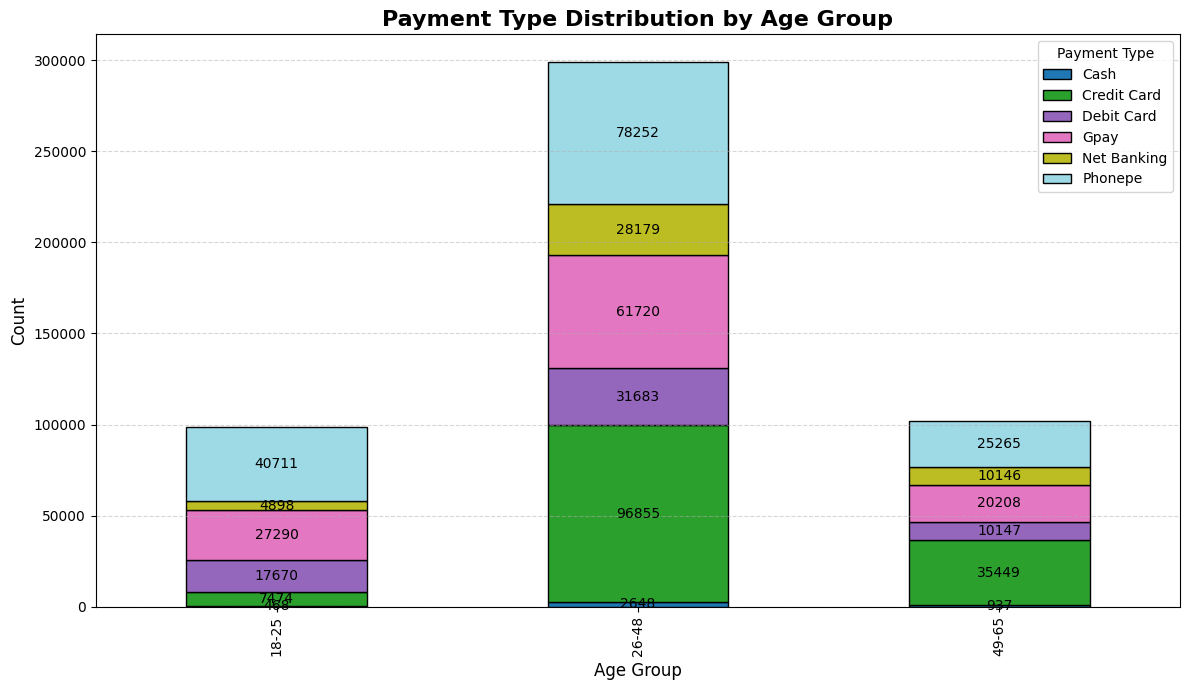

In [ ]:
stacked_data = (
    df_transactions.groupby(["age_group", "payment_type"], observed=True).size().unstack(fill_value=0)
)

ax = stacked_data.plot(
    kind="bar", 
    stacked=True, 
    figsize=(12, 7),
    colormap="tab20", 
    edgecolor="black"
)

for container in ax.containers:
    ax.bar_label(container, label_type="center", fontsize=10, color="black")

plt.title("Payment Type Distribution by Age Group", fontsize=16, fontweight="bold")
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(title="Payment Type")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

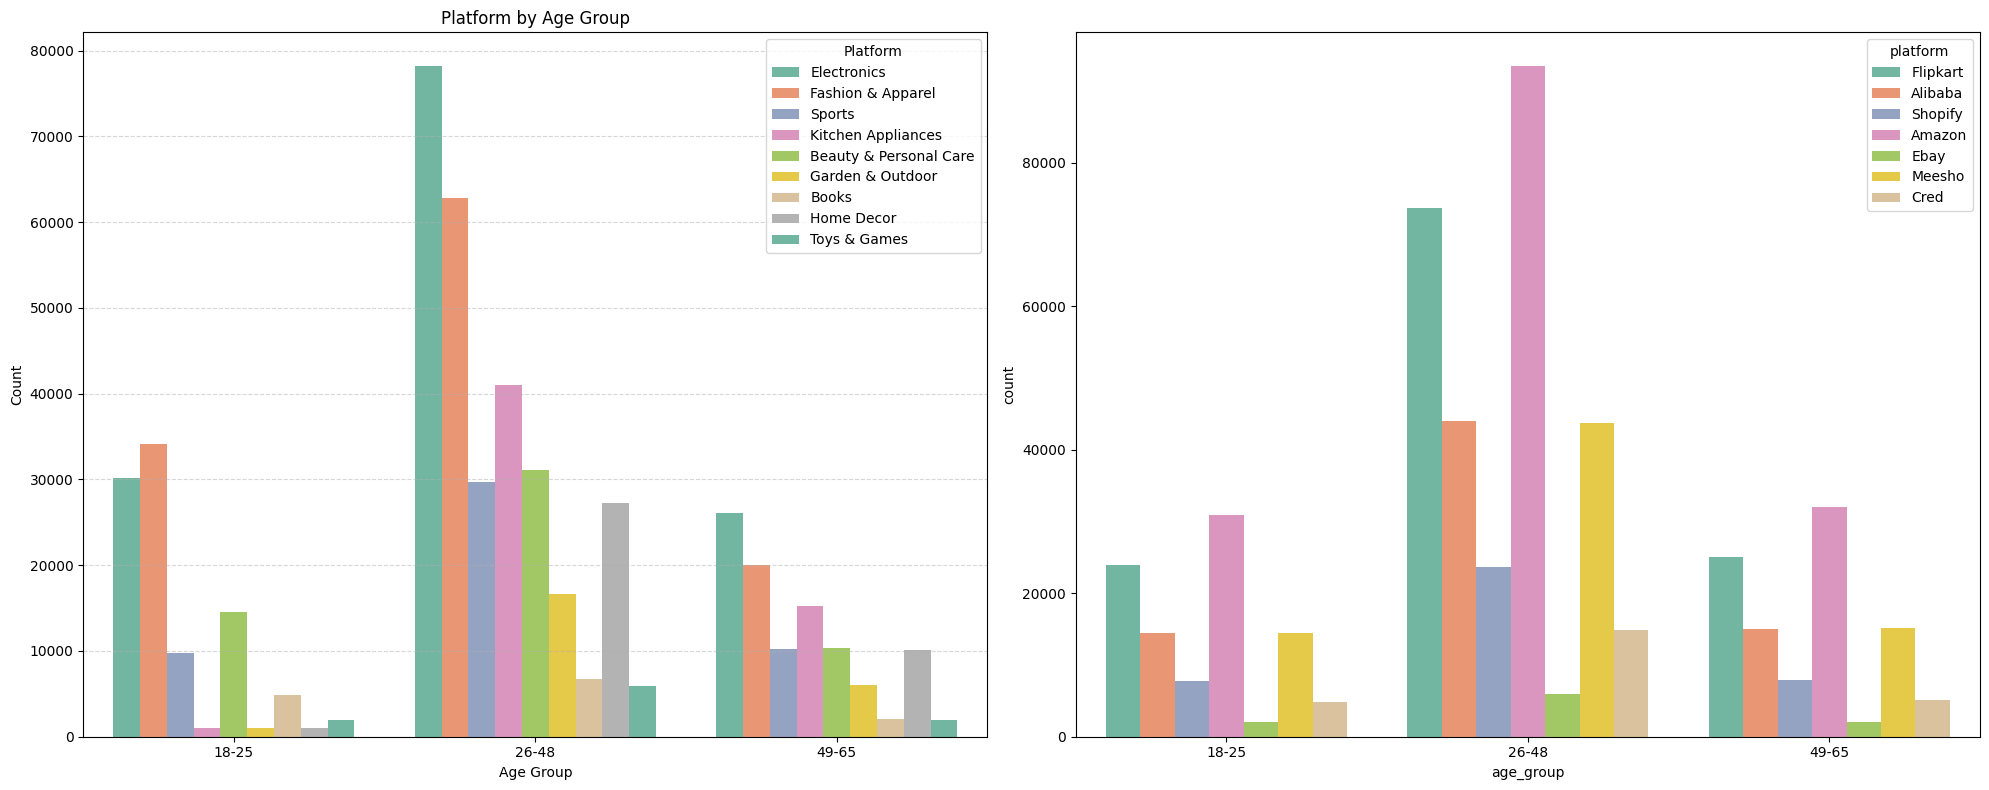

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

sns.countplot(
    data=df_transactions, x="age_group", hue="product_category", ax=ax1
)
ax1.set_title("Product Category by Age Group")
ax1.set_xlabel("Age Group")
ax1.set_ylabel("Count")
ax1.legend(title="Product Category", loc="upper right")
ax1.grid(axis="y", linestyle="--", alpha=0.5)

sns.countplot(
    data=df_transactions, x="age_group", hue="platform", ax=ax2
)
ax1.set_title("Platform by Age Group")
ax1.set_xlabel("Age Group")
ax1.set_ylabel("Count")
ax1.legend(title="Platform", loc="upper right")
ax1.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [107]:
age_group_metrics = pd.merge(df_customers, df_credit_profiles, "inner", "cust_id")
age_group_metrics = age_group_metrics.groupby("age_group", observed=True)[
    ["annual_income", "credit_limit", "credit_score"]
].mean().round(2)
age_group_metrics

,annual_income,credit_limit,credit_score
age_group,,,
18-25,36768.79,1188.13,484.44
26-48,136423.84,18986.20,588.07
49-65,253321.51,39925.25,694.12


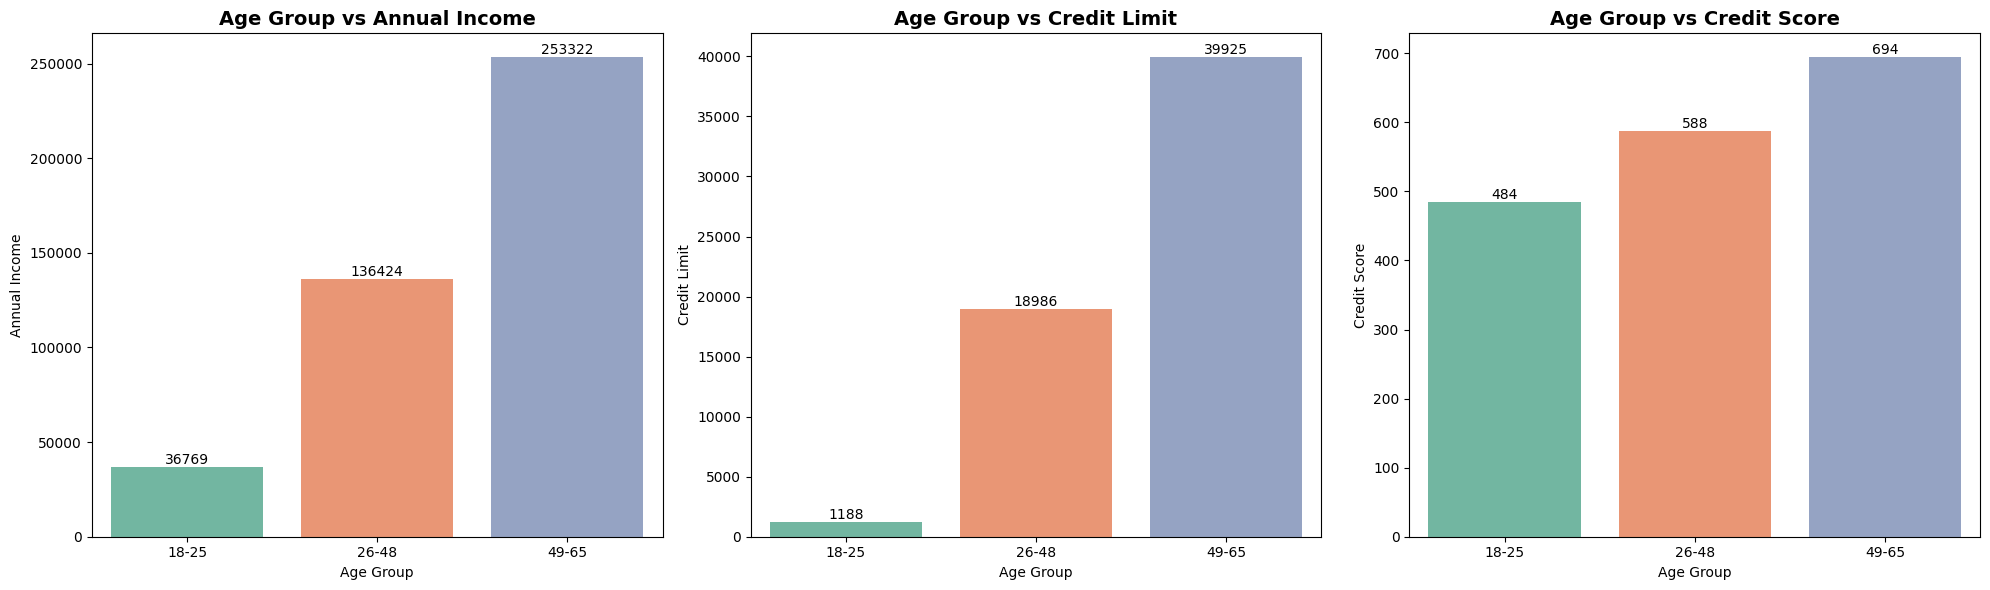

In [124]:
metrics = ["annual_income", "credit_limit", "credit_score"]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(
        x=age_group_metrics.index,
        y=metric,
        data=age_group_metrics,
        ax=ax,
        hue=metric,
        palette='Set2'
    )
    metric_title = metric.replace("_", " ").title()
    ax.set_title(f"Age Group vs {metric_title}", fontsize=14, fontweight="bold")
    ax.set_xlabel("Age Group")
    ax.set_ylabel(metric_title)
    ax.legend().remove()

    # Add bar labels
    for container in ax.containers:
        ax.bar_label(
            container, fmt="%.0f", label_type="edge", fontsize=10, color="black"
        )

plt.tight_layout()
plt.show()